In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from scipy import interpolate

#%matplotlib notebook

In [2]:
def change_vars(MG):
    """
    MG: np array of shape (3,...) containing 3D cartesian coordinates.
    returns spherical coordinates theta and phi (could return rho if needed)
    """
    rho = np.sqrt(np.sum(np.square(MG), axis=0))
    phi = np.squeeze(np.arctan2(MG[1, ...], MG[0, ...])) 
    theta = np.squeeze(np.arccos(MG[2, ...] / rho))
    # The center value is Nan due to the 0/0. So make it 0.
    theta[np.isnan(theta)] = 0
    rho = np.squeeze(rho)

    return theta, phi

def rev_chane_vars(phi, theta, rho=1):
    
    x = rho*np.sin(phi)*np.cos(theta)
    y = rho*np.sin(phi)*np.sin(theta)
    z = rho*np.cos(phi)
    DP = np.stack([x,y,z],axis=1)
    return DP
    
def arsNorm(A):
    # vectorized norm() function
    rez = A[:, 0] ** 2 + A[:, 1] ** 2 + A[:, 2] ** 2
    rez = np.sqrt(rez)
    return rez

def arsUnit(A, radius):
    # vectorized unit() functon
    normOfA = arsNorm(A)
    rez = A / np.stack((normOfA, normOfA, normOfA), 1)
    rez = rez * radius
    return rez

def sphereTriangulation(M, n_gamma):
    """
    Defines points on the sphere that we use for alpha (z) and beta (y') Euler angles sampling. We can have 24 points (numIterations=0), 72 (numIterations=1), 384 (numIterations=2) etc.
    Copied from the matlab function https://ch.mathworks.com/matlabcentral/fileexchange/38909-parametrized-uniform-triangulation-of-3d-circle-sphere
    M is the number total of orientation, i.e. number of points on the sphere * number of angles for the gamma angle (n_gamma).

    """
    
    F0 = 8 # number of faces of a octahedra
    V0 = 6 # number of vertices
    
    # the number of point after each iterations is given by V+n = 1.5*F0/3(4**n-1)+ V0 
    # numIter0 = int(np.log(((M/n_gamma)-V0)*(2/F0)+1)/(np.log(4)))
    # numIter1 = int(np.ceil(np.clip((np.log(M/(24))/np.log(n_gamma)+1)-1, a_min=0, a_max=None)))
    
    numIter = int(np.ceil(np.log(M-8)/np.log(n_gamma)-2))

    # function returns stlPoints fromat and ABC format if its needed,if not - just delete it and adapt to your needs
    radius = 1
    
    
    # basic Octahedron reff:http://en.wikipedia.org/wiki/Octahedron
    # ( ?1, 0, 0 )
    # ( 0, ?1, 0 )
    # ( 0, 0, ?1 )
    A = np.asarray([1, 0, 0]) * radius
    B = np.asarray([0, 1, 0]) * radius
    C = np.asarray([0, 0, 1]) * radius
    # from +-ABC create initial triangles which define oxahedron
    triangles = np.asarray([A, B, C,
                            A, B, -C,
                            # -x, +y, +-Z quadrant
                            -A, B, C,
                            -A, B, -C,
                            # -x, -y, +-Z quadrant
                            -A, -B, C,
                            -A, -B, -C,
                            # +x, -y, +-Z quadrant
                            A, -B, C,
                            A, -B, -C])  # -----STL-similar format
    # for simplicity lets break into ABC points...
    #triangles = np.unique(triangles,axis=0)
    selector = np.arange(0, len(triangles[:, 1]) - 2, 3)
    Apoints = triangles[selector, :]
    Bpoints = triangles[selector + 1, :]
    Cpoints = triangles[selector + 2, :]
    # in every of numIterations
    for iteration in range(numIter):
        # devide every of triangle on three new
        #        ^ C
        #       / \
        # AC/2 /_4_\CB/2
        #     /\ 3 /\
        #    / 1\ /2 \
        # A /____V____\B           1st              2nd              3rd               4th
        #        AB/2
        # new triangleSteck is [ A AB/2 AC/2;     AB/2 B CB/2;     AC/2 AB/2 CB/2    AC/2 CB/2 C]
        AB_2 = (Apoints + Bpoints) / 2
        # do normalization of vector
        AB_2 = arsUnit(AB_2, radius)  # same for next 2 lines
        AC_2 = (Apoints + Cpoints) / 2
        AC_2 = arsUnit(AC_2, radius)
        CB_2 = (Cpoints + Bpoints) / 2
        CB_2 = arsUnit(CB_2, radius)
        Apoints = np.concatenate((Apoints,  # A point from 1st triangle
                                  AB_2,  # A point from 2nd triangle
                                  AC_2,  # A point from 3rd triangle
                                  AC_2))  # A point from 4th triangle..same for B and C
        Bpoints = np.concatenate((AB_2, Bpoints, AB_2, CB_2))
        Cpoints = np.concatenate((AC_2, CB_2, CB_2, Cpoints))
    # now tur points back to STL-like format....
    numPoints = np.shape(Apoints)[0]

    selector = np.arange(numPoints)
    selector = np.stack((selector, selector + numPoints, selector + 2 * numPoints))

    selector = np.swapaxes(selector, 0, 1)
    selector = np.concatenate(selector)
    stlPoints = np.concatenate((Apoints, Bpoints, Cpoints))
    stlPoints = stlPoints[selector, :]

    return stlPoints, Apoints, Bpoints, Cpoints

def get_euler_angles(nbr_iter, zone= 0,n_gamma=4, z_rot_as_zone=True, desired_z_rot=4, cone_half_angle=60):
    '''
    Returns the zyz Euler angles with shape (M, 3) for the defined number of orientations M.
    (intrinsic Euler angles in the zyz convention)
    '''
    pi = np.pi
    
    M = int((4**(2+nbr_iter)+8)*(int(zone!=0)+int(zone==0)*(desired_z_rot/n_gamma)))
    print(f"You asked for {M} rotations with {desired_z_rot} rotation(s) along z axis")
    M_inf = int((4**(1+nbr_iter)+8))
    if M<M_inf and (desired_z_rot/n_gamma) < 1:
        M = int((4**(2+nbr_iter)+8))
    if M == 1:
        zyz = np.array([[0, 0, 0]])
    elif M == 2:
        zyz = np.array([[0, 0, 0], [180, 0, 0]])
    elif M == 4:  # Implement Klein's four group see Worrall and Brostow 2018
        zyz = np.array([[0, 0, 0], [180, 0, 0], [0, 180, 0], [180, 180, 0]])
    elif M == 8:  # Test of theta and phi.
        zyz = np.array(
            [[0, 0, 0], [0, 45, 315], [0, 90, 270], [0, 135, 225], [0, 180, 180], [0, 225, 135], [0, 270, 90],
             [0, 315, 45]])
    elif M == 124:  # as represented in Worrall and Brostow 2018, derived from the Caley's table
        # For intrinsic Euler angles (each row is for one of the six points on the sphere (theta,phi angles))
        zyz = np.array([[0, 0, 0], [0, 0, 90], [0, 0, 180], [0, 0, 270],
                        [0, 90, 0], [0, 90, 90], [0, 90, 180], [0, 90, 270],
                        [0, 180, 0], [0, 180, 90], [0, 180, 180], [0, 180, 270],
                        [0, 270, 0], [0, 270, 90], [0, 270, 180], [0, 270, 270],
                        [90, 90, 0], [90, 90, 90], [90, 90, 180], [90, 90, 270],
                        [90, 270, 0], [90, 270, 90], [90, 270, 180], [90, 270, 270]
                        ])

    else:
        # Parametrized uniform triangulation of 3D circle/sphere:

        i = np.log(M-8)/np.log(n_gamma)-2
        # No need for stlPoints AND A, B, C
        stlPoints, _, _, _ = sphereTriangulation(M,n_gamma)
        gamma_ROM = 2*pi
        #  0 all sphere
        #  1 upper hemisphere (UH) z>0, 
        #  11 right UH z>0 - y>0, 12 left UH z>0 - y<0
        #  21 front right quarter UH (QUH) z>0 - y>0 - x>0, 
        #  22 front left QHU z>0 - y<0 - x>0, 
        #  23 back right QUH z>0 - y>0 - x<0, 
        #  24 back left QHU z>0 - y<0 - x<0
        #
        #
        #  -1 lower hemisphere z < 0
        #  -11 right LH z<0 - y>0 ...
        if zone > 0:
            gamma_ROM /= 2
            if zone == 4:
                lim = np.cos(pi/3)
                lim = np.cos(cone_half_angle/180*np.pi)
            else:
                lim = 0
            stlPoints = stlPoints[stlPoints[:,2]>= lim]
            
            if zone%2 and zone > 10: #11, 21 or 23
                gamma_ROM /= 2
                stlPoints = stlPoints[stlPoints[:,1]>= 0]
                if zone == 21:
                    gamma_ROM /= 2
                    
                    stlPoints = stlPoints[stlPoints[:,0]>= 0]
                elif zone == 23:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]<= 0]
                    
            elif not zone%2 and zone > 10: #12, 22 or 24
                gamma_ROM /= 2
                stlPoints = stlPoints[stlPoints[:,1]<= -lim]
                if zone == 22:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]>= 0]
                elif zone == 24:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]<= 0]
                    
        elif zone < 0:
            gamma_ROM /= 2
            if abs(zone) == 4:
                lim = np.sign(zone)*np.cos(pi/3)
                lim = np.sign(zone)*np.cos(cone_half_angle/180*np.pi)
            else:
                lim = 0
            stlPoints = stlPoints[stlPoints[:,2]<= lim]
            if abs(zone)%2 and abs(zone) > 10: #-11, -21 or -23
                gamma_ROM /= 2
                stlPoints = stlPoints[stlPoints[:,1]>= 0]
                if zone == -21:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]>= 0]
                elif zone == -23:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]<= 0]
                    
            elif not abs(zone)%2 and abs(zone) > 10: #-12, -22 or -24
                gamma_ROM /= 2
                stlPoints = stlPoints[stlPoints[:,1]<= 0]
                if zone == -22:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]>= 0]
                elif zone == -24:
                    gamma_ROM /= 2
                    stlPoints = stlPoints[stlPoints[:,0]<= 0]
        # Then do spherical coordinates to get the alpha and beta angles uniformly sampled on the sphere.

        # Then do spherical coordinates to get the alpha and beta angles uniformly sampled on the sphere.
        alpha, beta = change_vars(np.swapaxes(stlPoints,0,1)) # The Euler angles alpha and beta are respectively theta and phi in spherical coord.

        if not z_rot_as_zone:
            gamma_ROM = 2*pi
        #n_gamma = min(n_gamma, max(M//np.unique(stlPoints, axis=0).shape[0],1))
        n_gamma = desired_z_rot
        step_gamma = gamma_ROM/n_gamma

        gamma2 = np.tile(np.linspace(0,gamma_ROM-step_gamma,n_gamma),alpha.shape[0])
        alpha2 = np.repeat(alpha,n_gamma)
        beta2 = np.repeat(beta,n_gamma)
        zyz2 = np.stack((alpha2,beta2,gamma2),axis=1)*180/pi
        zyz2[zyz2<0] = zyz2[zyz2<0]+360
        zyz2 = np.where(np.unique(zyz2,axis=0)==360., 0., np.unique(zyz2,axis=0))
        zyz = np.unique(zyz2,axis=0)
    

    return zyz


You asked for 264 rotations with 1 rotation(s) along z axis
number of points with z rotations: 13 and 13 points


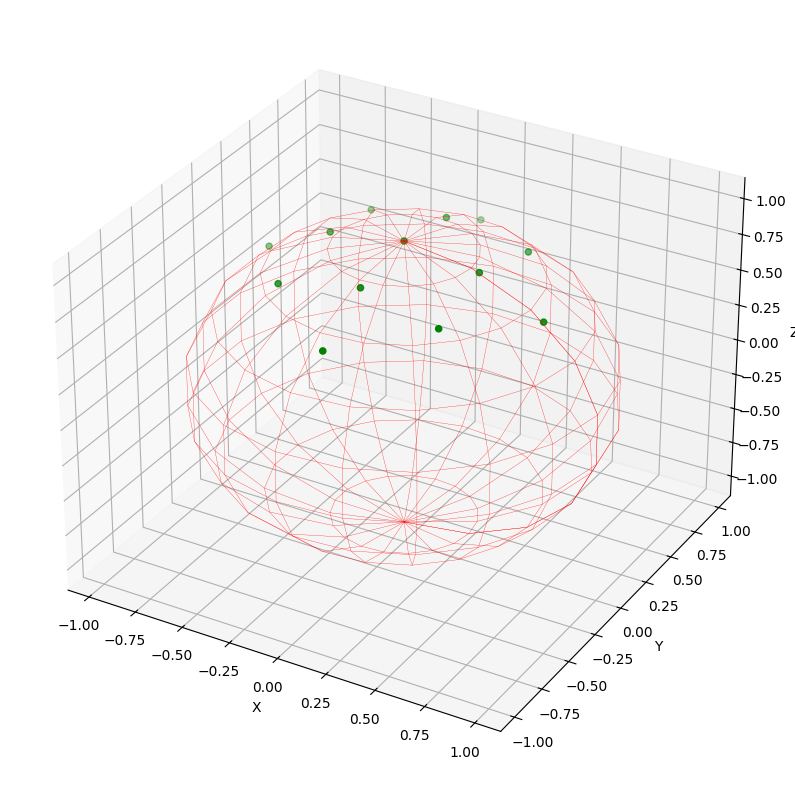

In [3]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
ax.plot_wireframe(np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v), color="r", linewidth=.2)

# possible number of orientations is equal to (4**(2+i)+8)*(n/n_gamma) with i=1,2,3,... where n=1,2,3,4 gives the z'' rotation

pi = np.pi
# zones :
#  0 all sphere
#  1 upper hemisphere (UH) z>0, 
#  Halves
#   11 right UH z>0 - y>0
#   12 left UH z>0 - y<0
#  Quarters
#   21 front right quarter UH (QUH) z>0 - y>0 - x>0
#   22 front left QHU z>0 - y<0 - x>0
#   23 back right QUH z>0 - y>0 - x<0
#   24 back left QHU z>0 - y<0 - x<0
#
#  Cone of 100

# For lower hemisphere, same but times -1

zone = 4
z_rot_as_zone = False
n_gamma=4
desired_z_rot = 1
# nbr of iterations
nbr_iter = 2
cone_half_angle = 60
zyzzw = get_euler_angles(nbr_iter=nbr_iter, n_gamma=n_gamma, zone=zone, z_rot_as_zone=z_rot_as_zone, desired_z_rot=desired_z_rot, cone_half_angle=cone_half_angle)

DP = rev_chane_vars(zyzzw[:,0]*pi/180,zyzzw[:,1]*pi/180)
DP2 = np.unique(DP,axis=0)
ax.scatter(DP2[:,0], DP2[:,1], DP2[:,2], color='g')
print(f'number of points with z rotations: {len(zyzzw)} and {DP2.shape[0]} points')

You asked for 4104 rotations with 1 rotation(s) along z axis
number of points with z rotations: 237 and 237 points


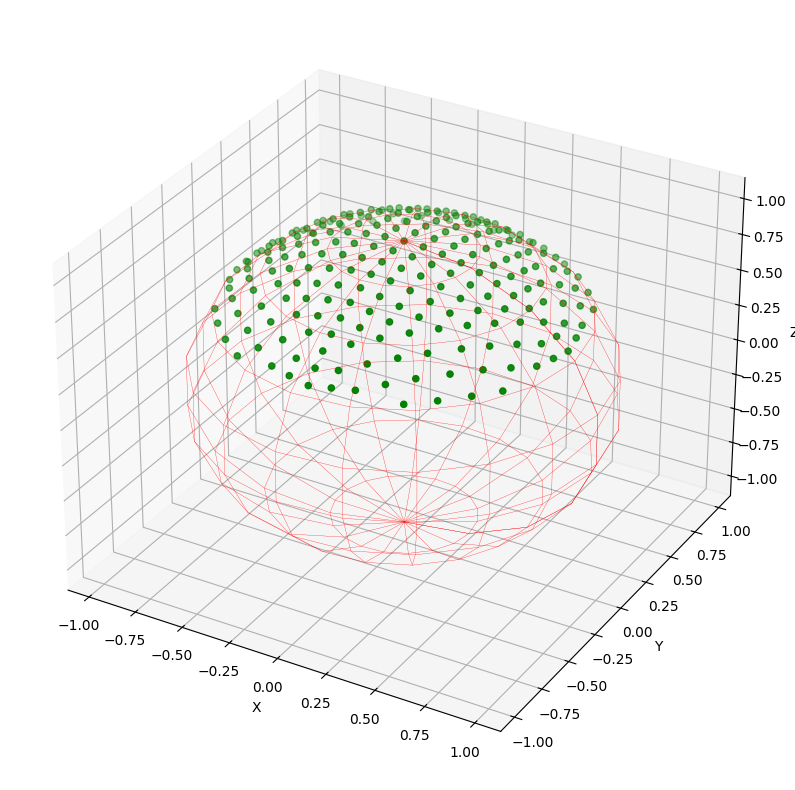

In [8]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
ax.plot_wireframe(np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v), color="r", linewidth=.2)

# possible number of orientations is equal to (4**(2+i)+8)*(n/n_gamma) with i=1,2,3,... where n=1,2,3,4 gives the z'' rotation

pi = np.pi
# zones :
#  0 all sphere
#  1 upper hemisphere (UH) z>0, 
#  Halves
#   11 right UH z>0 - y>0
#   12 left UH z>0 - y<0
#  Quarters
#   21 front right quarter UH (QUH) z>0 - y>0 - x>0
#   22 front left QHU z>0 - y<0 - x>0
#   23 back right QUH z>0 - y>0 - x<0
#   24 back left QHU z>0 - y<0 - x<0
#
#  Cone of 100

# For lower hemisphere, same but times -1

zone = 4
z_rot_as_zone = False
n_gamma=4
desired_z_rot = 1
# nbr of iterations
nbr_iter = 4
cone_half_angle = 60
zyzzw = get_euler_angles(nbr_iter=nbr_iter, n_gamma=n_gamma, zone=zone, z_rot_as_zone=z_rot_as_zone, desired_z_rot=desired_z_rot, cone_half_angle=cone_half_angle)

DP = rev_chane_vars(zyzzw[:,0]*pi/180,zyzzw[:,1]*pi/180)
DP2 = np.unique(DP,axis=0)
ax.scatter(DP2[:,0], DP2[:,1], DP2[:,2], color='g')
print(f'number of points with z rotations: {len(zyzzw)} and {DP2.shape[0]} points')